In [1]:
from itertools import combinations
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

In [11]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def create_dataframe_from_data(input_path: str):
    data_frames = []
    landmark_cols = []
    landmark_world_cols = [] 
    gesture_index = 0 

    for file_name in os.listdir(input_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(input_path, file_name)

            dataframe = pd.read_csv(file_path)

            # Gathers the landmark column names
            if(len(landmark_cols) == 0 and len(landmark_world_cols) == 0):
                landmark_cols = [col for col in dataframe.columns if col.startswith(("x", "y", "z"))]
                landmark_world_cols = [col for col in dataframe.columns if col.startswith(("wx", "wy", "wz"))]
            
            gesture = file_name.split("_")[0]
            gesture_index = int(file_name.split("_")[1].split(".")[0])

            dataframe["gesture"] = gesture
            dataframe["gesture_index"] = gesture_index

            dataframe.sort_values(by="frame", inplace=True)

            data_frames.append(dataframe)

    if len(data_frames) == 0:
        raise ValueError("Dataframe has no data")
    else:
        return pd.concat(data_frames, ignore_index=True), landmark_cols, landmark_world_cols

def split_dataset(dataframe: pd.DataFrame, label_col: str, train_ratio=0.6 , val_ratio=0.2, test_ratio=0.2):

    train_frames = []
    val_frames = []
    test_frames = []

    for _, gesture_data in dataframe.groupby("gesture_index"):
        n_frames = len(gesture_data)
        n_train = int(n_frames * train_ratio)
        n_val = int(n_frames * val_ratio)

        train_split = gesture_data.iloc[:n_train]
        val_split = gesture_data.iloc[n_train:n_train + n_val]
        test_split = gesture_data.iloc[n_train + n_val:]

        train_frames.append(train_split)
        val_frames.append(val_split)
        test_frames.append(test_split)
    
    train_set = pd.concat(train_frames).reset_index(drop=True)
    val_set = pd.concat(val_frames).reset_index(drop=True)
    test_set = pd.concat(test_frames).reset_index(drop=True)

    # Separate X and y
    X_train = train_set.drop(columns=[label_col])
    y_train = train_set[label_col]
    X_val = val_set.drop(columns=[label_col])
    y_val = val_set[label_col]
    X_test = test_set.drop(columns=[label_col])
    y_test = test_set[label_col]

    return X_train, y_train, X_val, y_val, X_test, y_test

def calculate_elapsed_time(df: pd.DataFrame):

    elapsed_lists = []

    for _, gesture_data in df.groupby("gesture_index"):
        avg_frame_rate = np.mean(gesture_data["frame_rate"])

        for i in gesture_data["frame"]:
            elapsed_time = i / avg_frame_rate
            elapsed_lists.append(elapsed_time)
        
    df['elapsed_time'] = elapsed_lists

    return df

def calculate_temporal_features_per_gesture(df: pd.DataFrame, landmark_cols: list):

    velocity_cols = [f"velocity_{col}" for col in landmark_cols]
    acceleration_cols = [f"acceleration_{col}" for col in landmark_cols]
    jerk_cols = [f"jerk_{col}" for col in landmark_cols]

    nan_df = pd.DataFrame(columns=velocity_cols + acceleration_cols + jerk_cols, dtype=float)
    df = pd.concat([df, nan_df], axis=1)

    df = df.sort_values(by=["gesture_index", "frame"])


    for _, gesture_data in df.groupby("gesture_index"):
        gesture_data_sorted = gesture_data.sort_values(by="frame")

        # Calculate time differences based on frame rate
        avg_frame_rate = np.mean(gesture_data_sorted["frame_rate"])
        time_diffs = gesture_data_sorted["frame"].diff().fillna(1) / avg_frame_rate
        
        # Calculate velocity (first derivative)
        velocities = gesture_data_sorted[landmark_cols].diff().div(time_diffs, axis=0).fillna(0)
        df.loc[gesture_data_sorted.index, velocity_cols] = velocities.values

        # Calculate acceleration (second derivative)
        accelerations = velocities.diff().div(time_diffs, axis=0).fillna(0)
        df.loc[gesture_data_sorted.index, acceleration_cols] = accelerations.values

        # Calculate jerk (third derivative)
        jerks = accelerations.diff().div(time_diffs, axis=0).fillna(0)
        df.loc[gesture_data_sorted.index, jerk_cols] = jerks.values

    return df

def calculate_landmark_distances(df: pd.DataFrame, landmark_cols: list):

    landmark_pairs = list(combinations(landmark_cols, 2))
    distance_columns = [f'distance_{idx1}_{idx2}' for idx1, idx2 in landmark_pairs]

    # Preallocate memory for distance_data DataFrame
    num_rows = len(df)
    num_cols = len(distance_columns)
    distance_data = pd.DataFrame(np.zeros((num_rows, num_cols)), columns=distance_columns)

    i = 0
    for _, gesture_data in df.groupby("gesture_index"):
        print(f"done {i}")
        i +=1
        gesture_data = gesture_data.sort_values(by="frame")

        for(col1, col2) in landmark_pairs:
            idx1 = col1[1:]
            idx2 = col2[1:]

            x1, y1, z1 = f'x{idx1}', f'y{idx1}', f'z{idx1}'
            x2, y2, z2 = f'x{idx2}', f'y{idx2}', f'z{idx2}'

            if all(pd.api.types.is_numeric_dtype(gesture_data[col]) for col in [x1, y1, z1, x2, y2, z2]): 
                distances = np.sqrt((gesture_data[x1] - gesture_data[x2])**2 + (gesture_data[y1] - gesture_data[y2])**2 + (gesture_data[z1] - gesture_data[z2])**2)
                distance_data.append(distances)

            else:
                raise ValueError("Landmark data types must be numeric for distance calculation")

    # Concatenate distance columns with original DataFrame
    df = pd.concat([df, distance_data], axis=1)

    return df  

def calculate_landmark_angles(df: pd.DataFrame, landmark_cols: list):
    angles_per_gesture_list = [] 

    for gesture_index, gesture_data in df.groupby("gesture_index"):
        gesture_data = gesture_data.sort_values(by="frame")
        gesture_points = gesture_data[landmark_cols].values# Calculate direction vectors between consecutive frames (we are using all the landmarks)
        
        gesture_vectors = np.diff(gesture_points, axis=0)

        if gesture_vectors.shape[0] < 2:
            continue

        # Calculate dot product and magnitudes (assuming 3D points)
        dot_products = np.sum(gesture_vectors[:-1] * gesture_vectors[1:], axis=1)
        magnitude1 = np.linalg.norm(gesture_vectors[:-1], axis=1)
        magnitude2 = np.linalg.norm(gesture_vectors[1:], axis=1)

        # Avoid dividing by zero or near-zero values
        mask = (magnitude1 > 1e-6) & (magnitude2 > 1e-6)
        dot_products[mask] /= (magnitude1[mask] * magnitude2[mask])

        # clip values stop prevent invalid input to arccos 
        dot_products = np.clip(dot_products, -1.0, 1.0)

        frame_angles = np.arccos(dot_products) * (180 / np.pi)

        # create dictionary with angles for each gesture
        angles_df = pd.DataFrame({
            'gesture_index': gesture_index,
            'frame': gesture_data['frame'].iloc[1:len(frame_angles)+1],  # Skip the first frame because diff reduces one row
            'angle': frame_angles
        })
        angles_per_gesture_list.append(angles_df)

    all_angles_df = pd.concat(angles_per_gesture_list, ignore_index=True)

    # Merge the angles DataFrame back to the original DataFrame
    df_with_angles = pd.merge(df, all_angles_df, on=['gesture_index', 'frame'], how='left')

    return df_with_angles

def calculate_gesture_stats(df: pd.DataFrame, landmark_cols: list, window_size: int = 5):
    # Create a dictionary to hold the rolling statistics
    stats_dict = {f"mean_{col}": [] for col in landmark_cols}
    stats_dict.update({f"var_{col}": [] for col in landmark_cols})
    stats_dict.update({f"skew_{col}": [] for col in landmark_cols})
    stats_dict.update({f"kurt_{col}": [] for col in landmark_cols})

    # Iterate through each gesture
    for gesture_index, gesture_data in df.groupby("gesture_index"):
        for col in landmark_cols:
            rolling_window = gesture_data[col].rolling(window=window_size, min_periods=1)
            
            stats_dict[f"mean_{col}"].extend(rolling_window.mean().tolist())
            stats_dict[f"var_{col}"].extend(rolling_window.var().tolist())
            stats_dict[f"skew_{col}"].extend(rolling_window.skew().tolist())
            stats_dict[f"kurt_{col}"].extend(rolling_window.kurt().tolist())
    
    # Convert stats_dict to DataFrame
    stats_df = pd.DataFrame(stats_dict, index=df.index)
    
    # Merge the original DataFrame with the stats DataFrame
    result_df = pd.concat([df, stats_df], axis=1)
    
    return result_df

In [23]:
def calculate_hand_motion_features(df: pd.DataFrame, landmark_cols: list):
    """
    List of features
        Elasped time - time of the the recorded gesture since frame 0 ✅
        velocity ✅
        acceleration ✅
        jerk ✅
        pairwise distances
        landmark angles
        gesture_stats - mean, variance, skewness, and kurtosis
    """
    df_copy = df.copy()

    # df_elapsed = calculate_elapsed_time(df_copy)
    # df_temporal_fe = calculate_temporal_features_per_gesture(df_copy, landmark_cols)
    # df_pairwse_fe = calculate_landmark_distances(df_copy, landmark_cols)
    # df_angles_fe = calculate_landmark_angles(df_copy, landmark_cols)
    df_gesture_fe = calculate_gesture_stats(df_copy, landmark_cols)

    # print(df_copy.columns.values.tolist())
    # print(df_temporal_fe.columns.values.tolist())
    # print(df_pairwse_fe.columns.values.tolist())
    # print(df_angles_fe.columns.values.tolist())
    # print(df_gesture_fe.columns.values.tolist())

    nan_columns = []
    nan_values = []

    for column in df_gesture_fe.columns:
        if(df_gesture_fe[column].isnull().any()):
            nan_columns.append(column)
            nan_values.append(df_gesture_fe[column].isnull().sum())

    fig, ax = plt.subplots(figsize=(30,10))
    plt.xticks(rotation=45)
    plt.bar(nan_columns, nan_values)
    plt.show()

    return 0

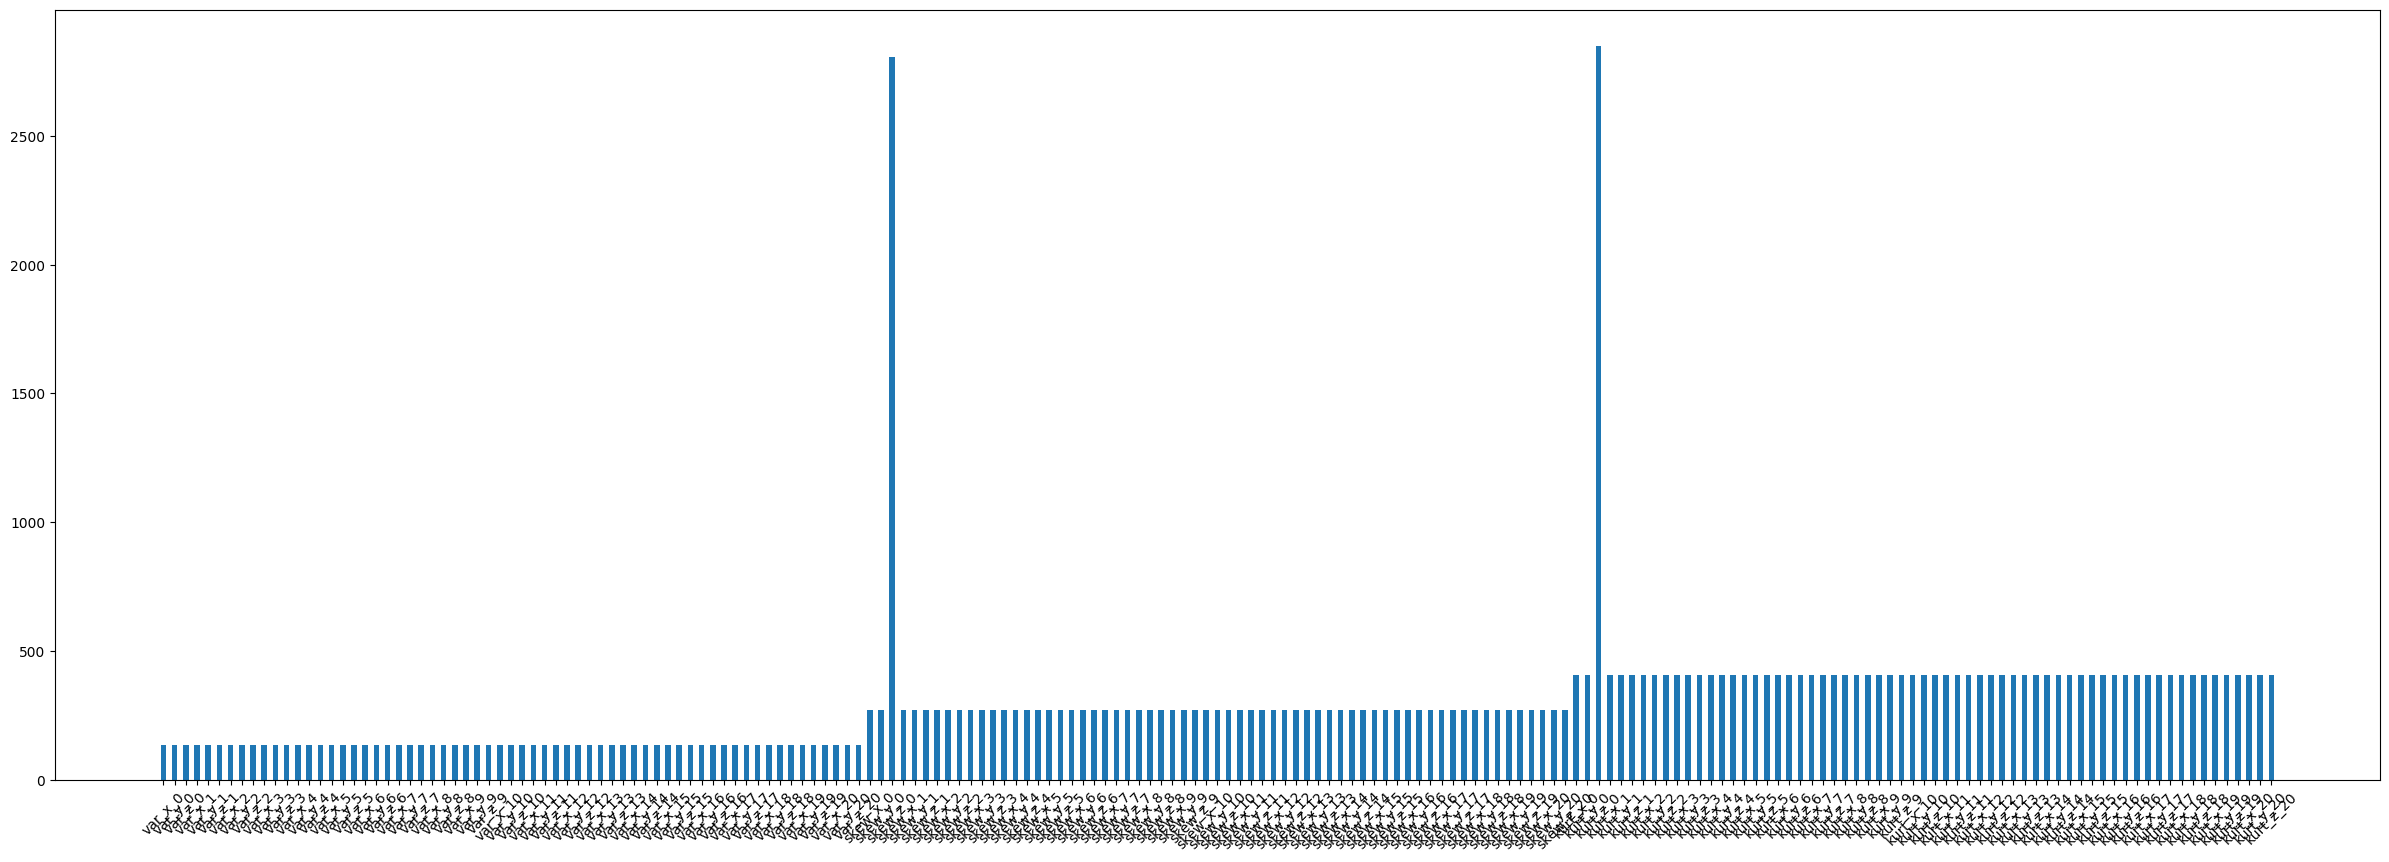

In [24]:
def main():
    input_dir = "C:\\Users\\Gen3r\\Documents\\capstone\\ml_model\\data\\data_2"

    # Step 1: Get data into frame
    dataframe, landmark_cols, landmark_world_cols = create_dataframe_from_data(input_dir)

    # Step 2: Split data into train test val sets
    X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(dataframe, "gesture")

    # Step 3: Feature Engineer
    X_train_fe = calculate_hand_motion_features(X_train, landmark_cols)

main()